## Regression Algorithms
- Partial Least Squares (PLS 2)
- Gradient Boosting
- Support Vector Machines (SVM)
- Locally Weighted Regression (LWR) based on K Nearest Neighbours

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.io import push_notebook

output_notebook()

Loading BokehJS ...

### Parameters to change

In [2]:
min_pixel = 1
max_pixel = 38

Cal1Name = "Protein"
Cal1MinValue = 5
Cal1MaxValue = 20

Cal2Name = "Moisture"
Cal2MinValue = 5
Cal2MaxValue = 25

Cal3Name = "Oil"
Cal3MinValue = 20
Cal3MaxValue = 60

## Training Data

In [3]:
#Training Data
path = "./Data/(1) Training/"
all_files = glob.glob(os.path.join(path, "*.csv")) #make list of paths

li = []

for filename in all_files:
    dfn = pd.read_csv(filename, index_col=None, header=0)
    li.append(dfn)

df_train = pd.concat(li, axis=0, ignore_index=True, sort=False)

#rename "cal1" "cal2" "cal3" and take away the asterisks from SpX
df_train = df_train.rename(index=str, columns={"Cal1": Cal1Name, "Cal2": Cal2Name, "Cal3": Cal3Name})
df_train = df_train.rename(index=str, columns={"cal1": Cal1Name, "cal2": Cal2Name, "cal3": Cal3Name})
for i in range(min_pixel, max_pixel+1):
    df_train = df_train.rename(index=str, columns={"Sp{}*".format(i) : "Sp{}".format(i)})

#randomise rows
df_train = df_train.sample(frac=1).reset_index(drop=True)

#Drop values of spectra if NaN
for i in range(min_pixel, max_pixel+1):
    df_train = df_train.dropna(subset=["Sp{}".format(i)])

#Drop lab values if NaN or outside ranges
df_train = df_train.dropna(subset=[Cal1Name])
df_train = df_train[df_train[Cal1Name] < Cal1MaxValue]
df_train = df_train[df_train[Cal1Name] > Cal1MinValue]
df_train = df_train[df_train[Cal2Name] < Cal2MaxValue]
df_train = df_train[df_train[Cal2Name] > Cal2MinValue]
if "Exclude" in df_train:
    df_train = df_train[df_train.Exclude != 'Y']
    
train_spectra = df_train.loc[:,"Sp{}".format(min_pixel):"Sp{}".format(max_pixel)].values
train_spectra_norm = train_spectra.copy()

train_values = [1,2,3]
if Cal1Name in df_train:
    train_values[0] = df_train[Cal1Name].values
if Cal2Name in df_train:
    train_values[1] = df_train[Cal2Name].values
if Cal3Name in df_train:
    train_values[2] = df_train[Cal3Name].values
    
df_train.head()

,SampleID,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,Sp8,Sp9,...,Sp34,Sp35,Sp36,Sp37,Sp38,Protein,Moisture,Exclude,Exclude.1,Exclude.2
0,8003.11.0,2.70258,2.62005,2.54935,2.49231,2.44081,2.39242,2.34279,2.29407,2.25341,...,2.16944,2.19727,2.28585,2.45126,2.66547,11.2,10.2,N,N,N
1,12515.14.4,3.16978,3.06483,2.97346,2.89422,2.82328,2.75748,2.69213,2.62866,2.57369,...,2.26311,2.28885,2.37589,2.54255,2.75528,14.7,9.9,N,N,N
2,11666.12.7,2.69017,2.61212,2.54435,2.48648,2.43634,2.38998,2.34314,2.29657,2.25690,...,2.07842,2.10088,2.17767,2.32703,2.51819,12.8,11.5,N,N,N
3,GC214069,2.66956,2.61987,2.57762,2.54158,2.50841,2.47640,2.44429,2.41387,2.39020,...,2.33608,2.35530,2.42043,2.54667,2.71692,14.1,8.7,N,N,N
4,SW138.9.6,2.68158,2.62427,2.57581,2.53580,2.50094,2.46747,2.43099,2.39327,2.36242,...,2.23456,2.25566,2.33587,2.49459,2.69936,9.9,9.1,N,N,N


(860, 38)
(860,)
[]
[]
[]


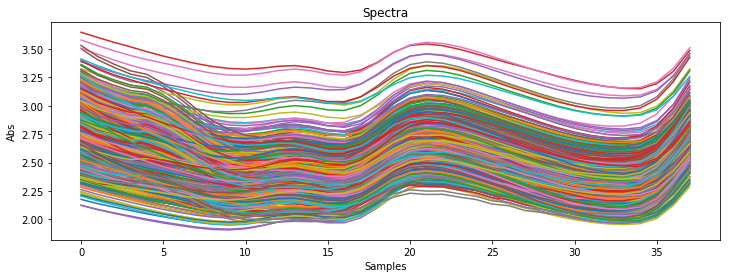

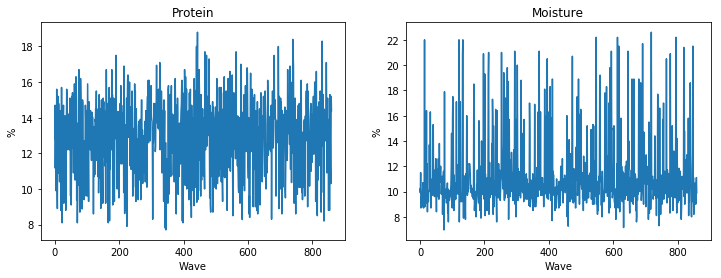

In [4]:
print(train_spectra.shape)
print(train_values[0].shape)
print(np.argwhere(np.isnan(train_values[0])))
print(np.argwhere(np.isnan(train_values[1])))
print(np.argwhere(np.isnan(train_values[2])))

plt.rcParams['figure.figsize'] = (12.0, 4.0) # set default size of plots
plt.plot(train_spectra.T)
plt.title('Spectra')
plt.ylabel('Abs')
plt.xlabel('Samples')
plt.show()

plt.subplot(121)
plt.plot(train_values[0])
plt.title(Cal1Name)
plt.ylabel('%')
plt.xlabel('Wave')

plt.subplot(122)
plt.plot(train_values[1])
plt.title(Cal2Name)
plt.ylabel('%')
plt.xlabel('Wave')
plt.show()

## Validation Data

In [5]:
#Validation Data
path = "./Data/(2) Validation/"
all_files = glob.glob(os.path.join(path, "*.csv")) #make list of paths

li = []

for filename in all_files:
    dfn = pd.read_csv(filename, index_col=None, header=0)
    li.append(dfn)

df_val = pd.concat(li, axis=0, ignore_index=True, sort=False)

#rename "cal1" "cal2" "cal3"
df_val = df_val.rename(index=str, columns={"Cal1": Cal1Name, "Cal2": Cal2Name, "Cal3": Cal3Name})
df_val = df_val.rename(index=str, columns={"cal1": Cal1Name, "cal2": Cal2Name, "cal3": Cal3Name})
for i in range(min_pixel, max_pixel+1):
    df_val = df_val.rename(index=str, columns={"Sp{}*".format(i) : "Sp{}".format(i)})

#randomise rows
df_val = df_val.sample(frac=1).reset_index(drop=True)

#Drop values of spectra if NaN
for i in range(min_pixel, max_pixel+1):
    df_val = df_val.dropna(subset=["Sp{}".format(i)])
    
#Drop lab values if NaN
df_val = df_val.dropna(subset=[Cal1Name])
df_val = df_val[df_val.Protein < Cal1MaxValue]
df_val = df_val[df_val.Protein > Cal1MinValue]
df_val = df_val[df_val.Moisture < Cal2MaxValue]
df_val = df_val[df_val.Moisture > Cal2MinValue]
if "Exclude" in df_val:
    df_val = df_val[df_val.Exclude != 'Y']

val_spectra = df_val.loc[:,"Sp{}".format(min_pixel):"Sp{}".format(max_pixel)].values
val_spectra_norm = val_spectra.copy()

val_values = [1,2,3]
if Cal1Name in df_train:
    val_values[0] = df_val[Cal1Name].values
if Cal2Name in df_train:
    val_values[1] = df_val[Cal2Name].values
if Cal3Name in df_train:
    val_values[2] = df_val[Cal3Name].values
    
df_val.head()

,SampleID,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,Sp8,Sp9,...,Slope5,Bias5,Slope6,Bias6,Slope7,Bias7,Slope8,Bias8,Slope9,Bias9
0,W2A,2.686482,2.633274,2.587911,2.548933,2.512360,2.474306,2.436833,2.403638,2.380607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W1A,2.410491,2.361218,2.319908,2.285004,2.252389,2.218084,2.184239,2.154636,2.134671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W5B,2.687411,2.636405,2.593122,2.556273,2.521629,2.485377,2.449831,2.418615,2.397257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W4A,2.629628,2.579664,2.537665,2.502079,2.468733,2.433794,2.399405,2.369268,2.348964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,W7A,2.335121,2.288501,2.249646,2.217101,2.186832,2.154917,2.123756,2.096866,2.078768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(18, 38)
(18,)
[]


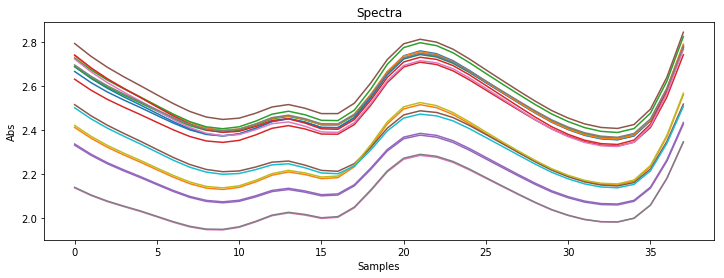

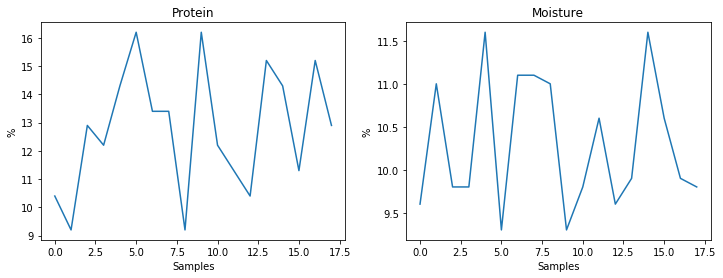

In [6]:
print(val_spectra.shape)
print(val_values[0].shape)
print(np.argwhere(np.isnan(val_values[0])))

plt.plot(val_spectra.T)
plt.title('Spectra')
plt.ylabel('Abs')
plt.xlabel('Samples')
plt.show()

plt.subplot(121)
plt.plot(val_values[0])
plt.title(Cal1Name)
plt.ylabel('%')
plt.xlabel('Samples')

plt.subplot(122)
plt.plot(val_values[1])
plt.title(Cal2Name)
plt.ylabel('%')
plt.xlabel('Samples')
plt.show()

## Reduce Dimensions with min_pixel and max_pixel

In [7]:
def Reduce_Dimensions(min_pixel, max_pixel, df_train, df_val):
    train_spectra = df_train.loc[:,"Sp{}".format(min_pixel):"Sp{}".format(max_pixel)].values
    val_spectra = df_val.loc[:,"Sp{}".format(min_pixel):"Sp{}".format(max_pixel)].values
    
    return train_spectra, val_spectra

## Principal Component Analysis (PCA)
Calculate PCs for training data and apply it to both training and validation sets

In [8]:
def Calculate_PCA(pca_components):
    #training data
    calibration_mean = train_spectra.mean(axis=0)
    calibration_std = train_spectra.std(axis=0)

    pca = PCA(n_components=pca_components)
    pca.fit(train_spectra)
    train_spectra_pca = pca.transform(train_spectra)

    scaler = MinMaxScaler(feature_range=(-1,1))
    train_spectra_pca = scaler.fit_transform(train_spectra_pca)

    #validation data
    val_spectra_pca = pca.transform(val_spectra)

    val_spectra_norm = val_spectra.copy()
    val_spectra_norm = (val_spectra_norm - calibration_mean)/calibration_std

    val_spectra_pca = scaler.transform(val_spectra_pca)
    
    return train_spectra_pca, val_spectra_pca

## Simple Linear Regression for Validation 

In [9]:
def CalculateLinearRegression(Name, prediction_values, lab_values, useSlope = True, slope = 1.0):    
    if useSlope:
        LR_X = prediction_values.reshape(prediction_values.shape[0],1)
        LR_y = lab_values.reshape(lab_values.shape[0],1)
        reg = LinearRegression().fit(LR_X, LR_y)
        slope = reg.coef_
        bias = reg.intercept_
        R2 = reg.score(LR_X, LR_y)
        
        predictionAdjusted = prediction_values * slope + bias
        predictionAdjusted = predictionAdjusted[0]
        slope = slope[0][0]  #Only need to return a single value 
        bias = bias[0]       #Only need to return a single value
        
    else:
        predictionAdjusted = prediction_values * slope
        bias = np.mean(predictionAdjusted - lab_values)
        predictionAdjusted = predictionAdjusted - bias
        
        LR_X = predictionAdjusted.reshape(predictionAdjusted.shape[0],1)
        LR_y = lab_values.reshape(lab_values.shape[0],1)
        reg = LinearRegression().fit(LR_X, LR_y)
        R2 = reg.score(LR_X, LR_y)
        
    error = (predictionAdjusted - lab_values)
    SEP = error.std()
    
    return slope, bias, R2, SEP

## Partial Least Squares Regression (PLS 2)

In [10]:
def Calculate_PLS(use_PCA_for_PLS, pls_components, return_model = False):
    if use_PCA_for_PLS:
        train_spectra_pls = train_spectra_pca
        val_spectra_pls = val_spectra_pca
    else:
        train_spectra_pls = train_spectra
        val_spectra_pls = val_spectra

    pls2 = PLSRegression(n_components=pls_components, scale=True)
    pls2.fit(train_spectra_pls, train_values[0])

    score_pls = pls2.score(train_spectra_pls, train_values[0])

    prediction_pls = pls2.predict(val_spectra_pls)
    Cal1Slope, Cal1Bias, Cal1R2_pls, Cal1SEP_pls = CalculateLinearRegression("Protein", prediction_pls.T[0], val_values[0])
    
    if return_model:
        return pls2
    else:
        return score_pls, Cal1R2_pls, Cal1SEP_pls

## Gradient Boost Algorithm

In [11]:
def Calculate_GBR(n_estimators, max_depth, min_samples_split, learning_rate, loss):
    params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split,
              'learning_rate': learning_rate, 'loss': loss, 'verbose': 0}
    gbr = GradientBoostingRegressor(**params)

    gbr.fit(train_spectra_pca, train_values[0])
    mse = mean_squared_error(train_values[0], gbr.predict(train_spectra_pca))

    score_gbr = gbr.score(train_spectra_pca, train_values[0])
    
    prediction_gbr = gbr.predict(val_spectra_pca)
    Cal1Slope, Cal1Bias, Cal1R2_gbr, Cal1SEP_gbr = CalculateLinearRegression("Protein", prediction_gbr.T, val_values[0])
    
    return score_gbr, Cal1R2_gbr, Cal1SEP_gbr

## Support Vector Machines (SVM)

In [12]:
def Calculate_SVM():
    svmr = svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
        kernel='rbf', shrinking=True, tol=0.001, verbose=False)
    svmr.fit(train_spectra_pca, train_values[0])

    score_svmr = svmr.score(train_spectra_pca, train_values[0])

    prediction_svmr = svmr.predict(val_spectra_pca)
    Cal1Slope, Cal1Bias, Cal1R2_svmr, Cal1SEP_svmr = CalculateLinearRegression("Protein", prediction_svmr.T, val_values[0])
    
    return score_svmr, Cal1R2_svmr, Cal1SEP_svmr

## Locally Weighted Regression (LWR)

In [13]:
def Calculate_LWR(k_neighbours, use_PCA_for_PLS, pls_components):
    if use_PCA_for_PLS:
        train_spectra_lwr = train_spectra_pca
        val_spectra_lwr = val_spectra_pca
    else:
        train_spectra_lwr = train_spectra
        val_spectra_lwr = val_spectra
        
    neigh = NearestNeighbors(k_neighbours)
    neigh.fit(train_spectra_lwr)

    prediction_lwr = np.empty(0)
    for spectra in val_spectra_lwr:
        indices = neigh.kneighbors(spectra.reshape(1, -1), k_neighbours, return_distance=False)
        lwr = PLSRegression(n_components=pls_components, scale=True)
        lwr.fit(train_spectra_lwr[indices[0]], train_values[0][indices[0]])
        prediction_lwr = np.append(prediction_lwr, lwr.predict(spectra.reshape(1, -1)))

    Cal1Slope, Cal1Bias, Cal1R2_lwr, Cal1SEP_lwr = CalculateLinearRegression("Protein", prediction_lwr.T, val_values[0])
    
    return 0, Cal1R2_lwr, Cal1SEP_lwr

## Results

In [14]:
def AppendResults(algorithm, score, R2, SEP, min_pixel, max_pixel, pca_component, pls_component = 0):
    results[algorithm]["score"] = np.append(results[algorithm]["score"], score)
    results[algorithm]["R2"] = np.append(results[algorithm]["R2"], R2)
    results[algorithm]["SEP"] = np.append(results[algorithm]["SEP"], SEP)
    results[algorithm]["min_pixel"] = np.append(results[algorithm]["min_pixel"], min_pixel)
    results[algorithm]["max_pixel"] = np.append(results[algorithm]["max_pixel"], max_pixel)
    results[algorithm]["pca_component"] = np.append(results[algorithm]["pca_component"], pca_component)
    if algorithm == "PLS":
        results[algorithm]["pls_component"] = np.append(results[algorithm]["pls_component"], pls_component)

In [15]:
%%time
min_pixel = 13
max_pixel = 30
pca_components = 20
pls_components = 15
use_PCA_for_PLS = False

results = {"PLS": {}, "GBR": {}, "SVM": {}, "LWR": {}}
for algo in results:
    results[algo] = {"score": np.empty(0), 
                     "R2": np.empty(0), 
                     "SEP": np.empty(0), 
                     "min_pixel": np.empty(0), 
                     "max_pixel": np.empty(0), 
                     "pca_component": np.empty(0), 
                     "pls_component": np.empty(0)}
    
for min_pix in range(1, min_pixel+1):
    for max_pix in range(38, max_pixel, -1):
        for pca_component in range(5,pca_components+1):
            if (max_pix - min_pix - 1) < pca_components: break

            train_spectra, val_spectra = Reduce_Dimensions(min_pix, max_pix, df_train, df_val)
            train_spectra_pca, val_spectra_pca = Calculate_PCA(pca_component)

            if pca_component == pca_components:
                for pls_component in range(1,pls_components):
                    try:
                        score_pls, R2_pls, SEP_pls = Calculate_PLS(use_PCA_for_PLS, pls_component)
                        AppendResults("PLS", score_pls, R2_pls, SEP_pls, min_pix, max_pix, pca_component, pls_component)
                    except:
                        pass

            #score_gbr, R2_gbr, SEP_gbr = Calculate_GBR(400, 4, 5, 0.01, 'ls')
            #AppendResults("GBR", score_gbr, R2_gbr, SEP_gbr, min_pix, max_pix, pca_component)

            score_svm, R2_svm, SEP_svm = Calculate_SVM()
            AppendResults("SVM", score_svm, R2_svm, SEP_svm, min_pix, max_pix, pca_component)

            if pca_component == pca_components:
                score_lwr, R2_lwr, SEP_lwr = Calculate_LWR(500, use_PCA_for_PLS, 12)        
                AppendResults("LWR", score_lwr, R2_lwr, SEP_lwr, min_pix, max_pix, pca_component)    
                
    print("{} out of {} iterations".format(min_pix, min_pixel))
    

1 out of 13 iterations
2 out of 13 iterations
3 out of 13 iterations
4 out of 13 iterations
5 out of 13 iterations
6 out of 13 iterations
7 out of 13 iterations
8 out of 13 iterations
9 out of 13 iterations
10 out of 13 iterations
11 out of 13 iterations
12 out of 13 iterations
13 out of 13 iterations
Wall time: 1min 18s


In [16]:
def plot_scores(algorithm, results):
    y = results[results >= 0.9]
    x = np.arange(y.shape[0])    

    plot = figure(plot_width=400, plot_height=400)
    plot.title.text = "{} Score (R2 for Training Data > 0.9)".format(algorithm)
    plot.line(x, y, line_width=2, color='red')
    
    return plot

In [17]:
show(gridplot([
    [plot_scores("PLS", results["PLS"]["score"]), plot_scores("GBR", results["GBR"]["score"])],
    [plot_scores("SVM", results["SVM"]["score"]), plot_scores("LWR", results["LWR"]["score"])]
]))

### Best PLS Model

In [18]:
print("Best PLS model")
index = np.argmax(results["PLS"]["score"])
print("index = {}".format(index))
print("score = {}".format(results["PLS"]["score"][index]))
print("R2 = {}".format(results["PLS"]["R2"][index]))
print("SEP = {}".format(results["PLS"]["SEP"][index]))
print("min_pixel = {}".format(results["PLS"]["min_pixel"][index]))
print("max_pixel = {}".format(results["PLS"]["max_pixel"][index]))
print("pls_component = {}".format(results["PLS"]["pls_component"][index]))

min_pix = int(results["PLS"]["min_pixel"][index])
max_pix = int(results["PLS"]["max_pixel"][index])
train_spectra, val_spectra = Reduce_Dimensions(min_pix, max_pix, df_train, df_val)
train_spectra_pca, val_spectra_pca = Calculate_PCA(int(results["PLS"]["pca_component"][index]))

pls2 = Calculate_PLS(use_PCA_for_PLS, int(results["PLS"]["pls_component"][index]), return_model = True)

if use_PCA_for_PLS:
    x = np.arange(pca_components)
    y = np.array(pls2.coef_.T[0])
else:
    x = np.arange(38)
    y = np.zeros(38)
    y[min_pix:max_pix+1] = pls2.coef_.T[0]

plot = figure()
model = plot.line(x, y, line_width=2, color='red')
show(plot, notebook_handle=True)

Best PLS model
index = 951
score = 0.9773555228894084
R2 = 0.9863738516016949
SEP = 0.2499635538396144
min_pixel = 9.0
max_pixel = 35.0
pls_component = 14.0


### Best SVM Model

In [19]:
print("Best SVM model")
index = np.argmax(results["SVM"]["score"])
print("index = {}".format(index))
print("score = {}".format(results["SVM"]["score"][index]))
print("R2 = {}".format(results["SVM"]["R2"][index]))
print("SEP = {}".format(results["SVM"]["SEP"][index]))
print("min_pixel = {}".format(results["SVM"]["min_pixel"][index]))
print("max_pixel = {}".format(results["SVM"]["max_pixel"][index]))
print("pca_component = {}".format(results["SVM"]["pca_component"][index]))

Best SVM model
index = 1099
score = 0.977475152536941
R2 = 0.9834791956542626
SEP = 0.2752363103668701
min_pixel = 9.0
max_pixel = 34.0
pca_component = 16.0


### Single Pass for all algorithms (Testing purposes)

In [20]:
%%time
min_pixel = 6
max_pixel = 35
pca_components = 15
pls_components = 15
use_PCA_for_PLS = False

train_spectra, val_spectra = Reduce_Dimensions(min_pixel, max_pixel, df_train, df_val)
train_spectra_pca, val_spectra_pca = Calculate_PCA(pca_components)
score_pls, R2_pls, SEP_pls = Calculate_PLS(use_PCA_for_PLS, pls_components)
score_gbr, R2_gbr, SEP_gbr = Calculate_GBR(400, 4, 5, 0.01, 'ls')
score_svm, R2_svm, SEP_svm = Calculate_SVM()
score_lwr, R2_lwr, SEP_lwr = Calculate_LWR(500, use_PCA_for_PLS, 15)

Wall time: 703 ms


In [21]:
print("Partial Least Squares (PLS)")
print("Training R^2 = {}".format(score_pls))
print("Prediction R^2 = {}".format(R2_pls))
print("SEP = {}\n".format(SEP_pls))

print("Gradient Boosting Regression (GBR)")
print("Training R^2 = {}".format(score_gbr))
print("Prediction R^2 = {}".format(R2_gbr))
print("SEP = {}\n".format(SEP_gbr))

print("Support Vector Machines (SVM)")
print("Training R^2 = {}".format(score_svm))
print("Prediction R^2 = {}".format(R2_svm))
print("SEP = {}\n".format(SEP_svm))

print("Locally Weighted Regression (LWR)")
print("Training R^2 = Local Value")
print("Prediction R^2 = {}".format(R2_lwr))
print("SEP = {}\n".format(SEP_lwr))

Partial Least Squares (PLS)
Training R^2 = 0.9770324099006475
Prediction R^2 = 0.9853404375145828
SEP = 0.2592690270249994

Gradient Boosting Regression (GBR)
Training R^2 = 0.9548182638816137
Prediction R^2 = 0.7331744320190483
SEP = 1.1061240998148325

Support Vector Machines (SVM)
Training R^2 = 0.9698685889953953
Prediction R^2 = 0.9774839426392108
SEP = 0.3213189259284393

Locally Weighted Regression (LWR)
Training R^2 = Local Value
Prediction R^2 = 0.9731238951501998
SEP = 0.3510534914625682

